In [25]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class for the image: purple


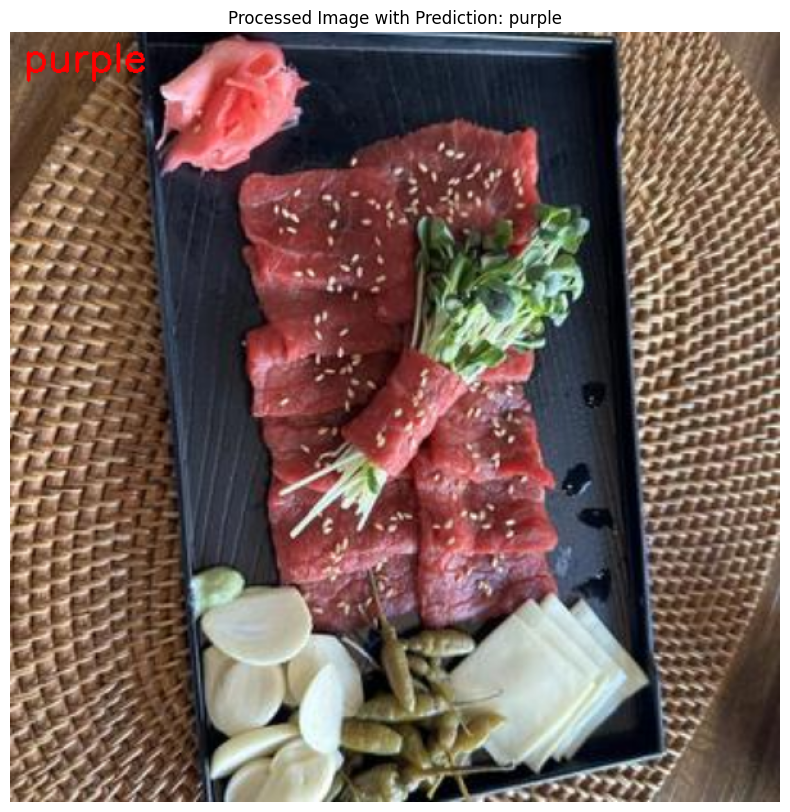

In [32]:
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Custom DepthwiseConv2D layer to handle potential version incompatibility
class CustomDepthwiseConv2D(tf.keras.layers.DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

tf.keras.utils.get_custom_objects()['DepthwiseConv2D'] = CustomDepthwiseConv2D

# --- Note for Colab Users ---
# Live webcam input (cv2.VideoCapture(0)) and displaying pop-up windows (cv2.imshow()) do NOT work in Google Colab.
# This code has been modified to process a single static image file.
# Please provide the path to your image file below.

# Replace with the path to your image file.
# Example: '/content/drive/MyDrive/path/to/your/image.jpg'
image_source = '/content/drive/MyDrive/육회연어/육회.jpg' # <--- REPLACE WITH YOUR IMAGE FILE PATH!

# Load the image
img = cv2.imread(image_source)

if img is None:
    print(f"Error: Could not load image from '{image_source}'.")
    print("Please ensure the path is correct and the image file exists.")
else:
    model=tf.keras.models.load_model('/content/drive/MyDrive/converted_keras/keras_model.h5', compile=False)
    classes = ['navy', 'purple', 'yellow', 'white', 'red', 'brown', 'blue', 'orange', 'black', 'blue green', 'green', 'pink', 'purple blue', 'green yellow', 'red purple']

    # Process the image
    img_processed = img.copy() # Make a copy for processing
    img_processed = cv2.flip(img_processed, 1) # 이미지 좌우 반전
    # Adjust these cropping values if your image aspect ratio is different
    # For a general image, you might not want to crop, or crop differently.
    # For now, keeping original video-like cropping for consistency if needed.
    # Original: img = img[:480, 80:560] (crops from a 480p wide image)
    # If your image is not 480p, this might not work as intended.
    # Let's simplify for a general image for now. If cropping is critical, specify target dimensions.

    # Resize for model input
    img_resized = cv2.resize(img_processed, (224, 224))

    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB) # Process on RGB
    img_input = img_rgb.astype(np.float32)/127.0 - 1
    img_input = np.expand_dims(img_input, axis = 0)

    predict = model.predict(img_input)

    idx = np.argmax(predict)
    predicted_class = classes[idx]

    # Prepare image for display (original aspect ratio or resize as preferred)
    # For displaying, we'll use the original loaded image to put text on, then resize.
    img_display = img.copy() # Use the original full image for display if not cropped heavily.
    # If you want text on the _cropped_ and _flipped_ image, use img_processed before resizing.

    # To make sure text is visible and proportional, let's resize the display image first if it's very large
    # And then ensure the text is applied to the image that will be shown.
    # Let's resize the original image to a display-friendly size, e.g., 600 pixels wide, keeping aspect ratio.
    (h_orig, w_orig) = img_display.shape[:2]
    aspect_ratio = w_orig / float(h_orig)
    new_width = 600
    new_height = int(new_width / aspect_ratio)
    img_display = cv2.resize(img_display, (new_width, new_height))

    # Draw text on the display image
    cv2.putText(img_display, text = predicted_class, org = (10, 30),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(0,0,255),
                thickness = 2)

    print(f"Predicted class for the image: {predicted_class}")

    # Display the processed frame using matplotlib
    plt.figure(figsize=(10, 10 * new_height / new_width)) # Adjust figure size proportionally
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)) # Convert back to RGB for matplotlib
    plt.title(f"Processed Image with Prediction: {predicted_class}")
    plt.axis('off') # Hide axes
    plt.show()